# Load extracted KG recipes and fit a GNN via PyTorch Geometric

This notebook provides an example of how to load in the extracted triples from https://www.allrecipes.com and fit them to a heterogenous GNN via pytorch geometric. 

In [1]:
import os, sys

import numpy as np 
import torch as tn
import torch.optim 
from torch.nn import ModuleDict 
import torch_geometric.transforms as T
from torch_geometric.nn import to_hetero, Linear, GATConv, HeteroConv,  SAGEConv
from torch_geometric.data import HeteroData
import matplotlib.pyplot as plt

sys.path = ['/Users/walder2/kg_uq/'] + sys.path
path_to_data = '/Users/walder2/kg_uq/recipe_data'

from recipe_data import recipe_kg_to_hetero

/Users/walder2/torch_geometric_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define the Hetero GNN

This is just one example. You can head to the docs here https://pytorch-geometric.readthedocs.io/en/latest/cheatsheet/gnn_cheatsheet.html and find heterogenous GNNs that handle features (and possibly lazy-initialization).

The GNN maps from `HeteroData()` to $\mathbb{R}^d$, with a linear layer at the bottom aggregating from each node type. If you change this, just be mindful of the loss function used later on. 

Note that the emebeddings for the features are `torch.float32`, so you need to be mindful of how you initialize the variables of the GNN.

In [2]:
log_sig = torch.nn.LogSigmoid()

class HeteroGNN(tn.nn.Module):
    def __init__(self, hidden_channels, emb_dim, num_layers, edge_types, node_types):
        super().__init__()
        
        self.emb_dim = emb_dim
        self.convs = tn.nn.ModuleList()
        
        for _ in range(num_layers):
            conv = HeteroConv({key : SAGEConv((-1, -1), hidden_channels, add_self_loops=False) for key in edge_types}, aggr='sum')
            self.convs.append(conv)
            
        self.lin_dict = ModuleDict({x: Linear(hidden_channels, emb_dim, bias=False) for x in node_types})
        
        
        
    def forward(self, x_dict, edge_index_dict):
        rv = tn.zeros(self.emb_dim)
        
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
            
        # may want to change the aggregation layer here
        for key, x in x_dict.items():
            rv += self.lin_dict[key](torch.mean(x, dim=0))
        return rv
        

# Load the data 

The returned dictionary contains:

    - 'train': a list of `HeteroData()` objects (one for each subgraph)
    - 'kg': the KG as a `DataFrame`
    - 'embedding_maps': Tuple of node type sentence enumeration, and corresponding node type embeddings
    
You need to specify the path to `./recipe_data` in `data_dir`. You can speficy an embedding model for the sentences by passing a string to `sentence_transformer_model`, which corresponds to a type of embeddings for `SentenceTransformer` objects (see https://www.sbert.net/). `Passing `undirected = True`, supplies reverse edges for fitting. 
    

In [3]:
data_dict = recipe_kg_to_hetero(data_dir=path_to_data, sentence_transformer_model='all-MiniLM-L6-v2', undirected=True)

### Looking at a KG subgraph

We can take a look at the first subgraph extracted below. 

In [17]:
kg = data_dict['kg']
kg[kg['kg_idx'] == 1]

,head,head_type,relation,tail,tail_type,kg_idx,kg_name
13,baked apples,recipe,hasCharacteristic,147 calories,nutrition,1,baked apples
14,baked apples,recipe,hasCharacteristic,1g fat,nutrition,1,baked apples
15,baked apples,recipe,hasCharacteristic,37g carbs,nutrition,1,baked apples
16,baked apples,recipe,hasCharacteristic,1g protein,nutrition,1,baked apples
17,baked apples,recipe,cookTime,45 mins,measurement,1,baked apples
18,baked apples,recipe,recipeInstruction,preheat the oven to 350 degrees F,instruction,1,baked apples
19,baked apples,recipe,recipeInstruction,Grease a large baking dish with butter,instruction,1,baked apples
20,baked apples,recipe,recipeInstruction,"mix brown sugar, vanilla sugar, cinnamon, and ...",instruction,1,baked apples
21,baked apples,recipe,recipeInstruction,"Layer sliced apples in the baking dish, sprink...",instruction,1,baked apples
22,baked apples,recipe,recipeInstruction,Bake for 30 minutes,instruction,1,baked apples


Looking at the contents of, `tail` we may want to do some text clean up. We won't do that here, but should consider that at a different time.

# Initialize the GNN

`emb_dim` is the dimension mapped to by the encoder. You need to specify the edge types and node types to initialize the GNN as defined. 


Model is fit by performing an N-ary classification. Each graph is embedded to get $f_{\theta}(G_i) = \boldsymbol{d}_i$. The optimization maximizes 

$$ \sum_{i=1}^{N} P(G_i \vert D ) = \sum_{i=1}^{n} \frac{\sigma(\boldsymbol{d}_i^{T}\boldsymbol{d}_i)}{\sum_{i=1}^{N}  \sigma(\boldsymbol{d}_i^{T}\boldsymbol{d}_j) }, $$

where $\sigma(x) = \frac{1}{1 + \exp(-x)}$ is a sigmoid function This is not a great way to do this, but for a first pass try it out. 

In [5]:
emb_dim = 10 
train = data_dict['train']

edge_types = tuple(set((y for x in train for y in x.edge_types)))
node_types = tuple((y for x in train for y in x.node_types))

encoder = HeteroGNN(hidden_channels=16, num_layers=2, emb_dim=emb_dim, edge_types=edge_types, node_types=node_types)

In [6]:
epochs = 100
ntrain = len(train)
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.90)

for epoch in range(epochs):
    optimizer.zero_grad()
    
    rv = tn.zeros((ntrain, emb_dim))
    
    for i in range(ntrain):
        rv[i] = encoder(train[i].x_dict, train[i].edge_index_dict)
        
    d_ij = log_sig(tn.matmul(rv, rv.T))
    loss = -tn.sum(tn.diag(d_ij) - tn.logsumexp(d_ij, dim=1))
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    if (epoch+1) % 10 == 0:
        print('Epoch %s, loss %s' % (repr(epoch+1), repr(loss.detach())))
        

Epoch 10, loss tensor(143.5373)
Epoch 20, loss tensor(137.0921)
Epoch 30, loss tensor(131.5206)
Epoch 40, loss tensor(130.9979)
Epoch 50, loss tensor(130.5631)
Epoch 60, loss tensor(130.5640)
Epoch 70, loss tensor(130.5717)
Epoch 80, loss tensor(130.5627)
Epoch 90, loss tensor(130.5627)
Epoch 100, loss tensor(130.5627)


## Lets take a look at which recipes were similar.

Things like cookies should be close to cookies, but maybe ingredients and directions have an influence on the embeddings. 

First lets get the normalized embeddings of the recipe kgs trained on.

In [7]:
# embed the KG subgraphs
train_emb = torch.zeros((ntrain, emb_dim))

for i in range(ntrain):
    train_emb[i] = encoder(train[i].x_dict, train[i].edge_index_dict)

train_emb /= torch.pow(torch.sum(train_emb**2, dim=1, keepdim=True),0.5)

We can look at cosine similarity for each embedded recipe...

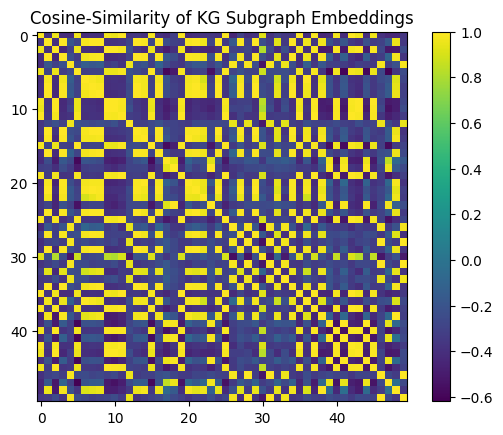

In [8]:
# cosine similarity plot then pick out the kgs that are similar
cmat = torch.matmul(train_emb, train_emb.T).detach().numpy()

fig, ax = plt.subplots()
c = ax.imshow(cmat)
ax.set_title('Cosine-Similarity of KG Subgraph Embeddings')
fig.colorbar(c)
None


And look at the top 5 most similar recipes for each recipe..

In [9]:
k = 5
for i, x in enumerate(kg['kg_name'].unique()):
    top = [np.unique(kg[kg['kg_idx'] == i]['kg_name'])[0] for i in np.argsort(-cmat[i, :])[1:(k+1)]]
    top = '\n\t- '.join(['']+top)
    print(f'Top {k} neighbors of {x} are: {top}\n')

Top 5 neighbors of apple spinach salad are: 
	- pecan chicken salad
	- chicken noodle soup
	- shrimp and pepper stir fry
	- egg drop soup
	- pepperoni pizza grilled cheese

Top 5 neighbors of baked apples are: 
	- chocolate cookies
	- carmel apple chocolate bark
	- lemon shortbread cookies
	- gooey butter cookies
	- peanut butter pie

Top 5 neighbors of baked italian sub are: 
	- sloppy joes
	- carrot rasin salad
	- chef john's chicken tortilla soup
	- tavern pizza
	- pork stir fry

Top 5 neighbors of banana cream pie are: 
	- peanut butter pie
	- chocolate cookies
	- baked apples
	- lemon shortbread cookies
	- carmel apple chocolate bark

Top 5 neighbors of beef and green bean stir fry are: 
	- healthier apple crisp
	- hummingbird cake
	- no yeast pizza crust
	- thin crust pizza dough
	- vanilla frozen yogurt

Top 5 neighbors of bonbons are: 
	- chocolate strawberry cheesecake
	- greek couscous salad
	- egg drop soup
	- pepperoni pizza grilled cheese
	- chicken noodle soup

Top 5 neig

# Subgraph Matching: Removing Random Edges

Lets see how well we can match subgraphs of recipes to their respective recipes. We will randomly remove edges from each subgraph and see which original recipe embedding is closest. 

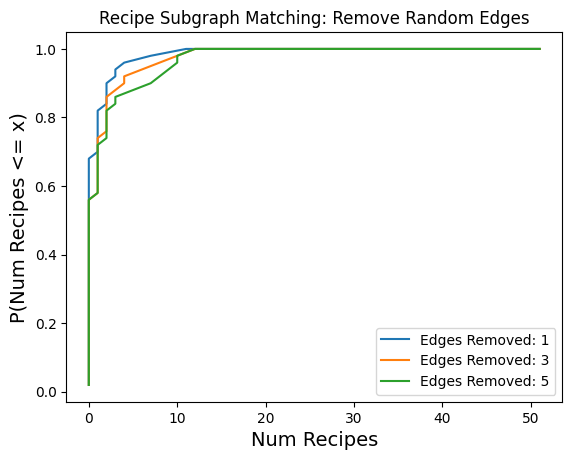

In [12]:
test = [x.clone() for x in train]
rng = np.random.RandomState(1)

fig, ax = plt.subplots()
ax.set_ylabel("P(Num Recipes <= x)", fontsize=14)
ax.set_xlabel('Num Recipes', fontsize=14)
ax.title.set_text('Recipe Subgraph Matching: Remove Random Edges') 

y_axis = np.ones(ntrain+1)
y_axis[:-1] = np.arange(1.0,ntrain+1)/ntrain

for num_edge in [1, 3, 5]:
    
    sd = np.zeros(ntrain+1, dtype=int)
    sd[0] = ntrain+1
    for i, x in enumerate(test):

        triples = [k for k, v in x.edge_index_dict.items() if v.shape[1] > 0]
        rem_triple = triples[rng.randint(len(triples))]

        del_idx = rng.randint(x.edge_index_dict[rem_triple].shape[1])
        tmp0 = x.edge_index_dict[rem_triple][:, del_idx]

        left = x.edge_index_dict[rem_triple][:, :del_idx]
        right = x.edge_index_dict[rem_triple][:, (del_idx+1):]
        x[rem_triple].edge_index = torch.column_stack([left, right])

        if 'rev_' in rem_triple[1]:
            rev_rel = rem_triple[1].split('rev_')[1]
        else:
            rev_rel = 'rev_' + rem_triple[1]

        tmp1 = x.edge_index_dict[rem_triple[2], rev_rel, rem_triple[0]]
        del_idx = torch.bitwise_and(tmp1[0] != tmp0[1], tmp1[1] != tmp0[0])
        x[rem_triple[2], rev_rel, rem_triple[0]].edge_index = tmp1[:, del_idx]
        
        test_emb = encoder(x.x_dict, x.edge_index_dict)
        test_emb /= torch.pow(torch.sum(test_emb**2), 0.5)
        
        dists = torch.pow(torch.sum(torch.pow(train_emb - test_emb,2),dim=1), 0.5)
        sd[i+1] = int(torch.nonzero(torch.argsort(dists) == i)[0])
    
    ax.plot(np.sort(sd), y_axis, label="Edges Removed: %s" % repr(num_edge))
    
ax.legend()
plt.show()